# Test Cell Embedding Generation

This notebook tests the cell embedding pipeline with a small sample (100 healthy + 100 cancer cells).

In [8]:
import sys
from pathlib import Path

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import numpy as np
import cellxgene_census
import scanpy as sc
from scipy.sparse import issparse

from model.cell_embeddings import CellEmbedder, load_gene_embeddings
from preprocess_data.config import OUTPUT_FILES, CENSUS_QUERY_PARAMS

## 1. Load Gene Embeddings

In [9]:
gene_to_embedding = load_gene_embeddings(OUTPUT_FILES["gene_to_embedding"])
print(f"Loaded {len(gene_to_embedding)} gene embeddings")

# Check embedding dimension
sample_gene = next(iter(gene_to_embedding))
sample_emb = gene_to_embedding[sample_gene]
print(f"Sample gene: {sample_gene}")
print(f"Embedding shape: {sample_emb.shape}")
print(f"Embedding dtype: {sample_emb.dtype}")

Loaded 19294 gene embeddings
Sample gene: MT-ND1
Embedding shape: (512,)
Embedding dtype: float32


## 2. Query Small Sample from Census (Limited at Query Level)

First get cell IDs, then fetch only 100 cells per condition.

In [10]:
N_CELLS = 500  # cells per condition

healthy_filter = CENSUS_QUERY_PARAMS["healthy_filter"]
cancer_filter = CENSUS_QUERY_PARAMS["cancer_filter"]

print(f"Healthy filter: {healthy_filter}")
print(f"Cancer filter: {cancer_filter}")

Healthy filter: tissue_general == 'breast' and disease == 'normal' and assay == "10x 3' v3" and is_primary_data == True
Cancer filter: tissue_general == 'breast' and disease == 'breast cancer' and assay == "10x 3' v3" and is_primary_data == True


In [11]:
# First, get cell metadata (soma_joinid) without expression data
print("Getting cell IDs from Census (metadata only)...")

with cellxgene_census.open_soma(census_version="stable") as census:
    # Get healthy cell IDs
    healthy_obs = census["census_data"]["homo_sapiens"].obs.read(
        value_filter=healthy_filter,
        column_names=["soma_joinid"]
    ).concat().to_pandas()
    print(f"Found {len(healthy_obs)} healthy cells")
    
    # Get cancer cell IDs  
    cancer_obs = census["census_data"]["homo_sapiens"].obs.read(
        value_filter=cancer_filter,
        column_names=["soma_joinid"]
    ).concat().to_pandas()
    print(f"Found {len(cancer_obs)} cancer cells")

Getting cell IDs from Census (metadata only)...


The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


Found 1726582 healthy cells
Found 34164 cancer cells


In [12]:
# Sample N_CELLS from each
np.random.seed(12335)

healthy_sample_ids = healthy_obs["soma_joinid"].sample(n=min(N_CELLS, len(healthy_obs))).tolist()
cancer_sample_ids = cancer_obs["soma_joinid"].sample(n=min(N_CELLS, len(cancer_obs))).tolist()

print(f"Sampled {len(healthy_sample_ids)} healthy cell IDs")
print(f"Sampled {len(cancer_sample_ids)} cancer cell IDs")

Sampled 500 healthy cell IDs
Sampled 500 cancer cell IDs


In [13]:
# Now fetch expression data for only these cells
print("\nFetching expression data for sampled cells...")

with cellxgene_census.open_soma(census_version="stable") as census:
    # Fetch healthy cells
    print("Fetching healthy cells...")
    healthy_adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        measurement_name="RNA",
        X_name="raw",
        obs_coords=healthy_sample_ids,
    )
    print(f"Retrieved {healthy_adata.n_obs} healthy cells × {healthy_adata.n_vars} genes")
    
    # Fetch cancer cells
    print("Fetching cancer cells...")
    cancer_adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        measurement_name="RNA",
        X_name="raw",
        obs_coords=cancer_sample_ids,
    )
    print(f"Retrieved {cancer_adata.n_obs} cancer cells × {cancer_adata.n_vars} genes")


Fetching expression data for sampled cells...


The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


Fetching healthy cells...


/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Retrieved 500 healthy cells × 61888 genes
Fetching cancer cells...


/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Retrieved 500 cancer cells × 61888 genes


## 3. Apply QC Filters

In [14]:
min_genes = CENSUS_QUERY_PARAMS["min_genes"]
# Use lower min_cells for small sample
min_cells = 3  # Override config for small sample

print(f"QC thresholds: min_genes={min_genes}, min_cells={min_cells}")

# Apply QC to healthy
print(f"\nHealthy before QC: {healthy_adata.n_obs} cells × {healthy_adata.n_vars} genes")
sc.pp.filter_cells(healthy_adata, min_genes=min_genes)
sc.pp.filter_genes(healthy_adata, min_cells=min_cells)
print(f"Healthy after QC: {healthy_adata.n_obs} cells × {healthy_adata.n_vars} genes")

# Apply QC to cancer
print(f"\nCancer before QC: {cancer_adata.n_obs} cells × {cancer_adata.n_vars} genes")
sc.pp.filter_cells(cancer_adata, min_genes=min_genes)
sc.pp.filter_genes(cancer_adata, min_cells=min_cells)
print(f"Cancer after QC: {cancer_adata.n_obs} cells × {cancer_adata.n_vars} genes")

QC thresholds: min_genes=200, min_cells=3

Healthy before QC: 500 cells × 61888 genes
Healthy after QC: 500 cells × 16150 genes

Cancer before QC: 500 cells × 61888 genes
Cancer after QC: 500 cells × 17538 genes


## 4. Check Gene Overlap with Embeddings

In [15]:
print("Converting gene indices to symbols...")
print(f"Before: {healthy_adata.var_names[:5].tolist()}")

healthy_adata.var_names = healthy_adata.var['feature_name'].values
cancer_adata.var_names = cancer_adata.var['feature_name'].values

print(f"After: {healthy_adata.var_names[:5].tolist()}")

print(healthy_adata.var.columns)
print(healthy_adata.var.head())

Converting gene indices to symbols...
Before: ['0', '1', '2', '3', '4']
After: ['LINC01409', 'NOC2L', 'PERM1', 'ENSG00000272512.1', 'HES4']
Index(['soma_joinid', 'feature_id', 'feature_name', 'feature_type',
       'feature_length', 'nnz', 'n_measured_obs', 'n_cells'],
      dtype='object')
                   soma_joinid       feature_id       feature_name  \
LINC01409                    0  ENSG00000237491          LINC01409   
NOC2L                        1  ENSG00000188976              NOC2L   
PERM1                        2  ENSG00000187642              PERM1   
ENSG00000272512.1            3  ENSG00000272512  ENSG00000272512.1   
HES4                         4  ENSG00000188290               HES4   

                     feature_type  feature_length       nnz  n_measured_obs  \
LINC01409                  lncRNA            1059   7958785        92252850   
NOC2L              protein_coding            1244  18685092       105784525   
PERM1              protein_coding            2765 

In [16]:
available_genes = set(gene_to_embedding.keys())

healthy_genes = set(healthy_adata.var_names)
cancer_genes = set(cancer_adata.var_names)

healthy_common = healthy_genes & available_genes
cancer_common = cancer_genes & available_genes

print(f"Healthy genes with embeddings: {len(healthy_common)}/{len(healthy_genes)} ({len(healthy_common)/len(healthy_genes)*100:.1f}%)")
print(f"Cancer genes with embeddings: {len(cancer_common)}/{len(cancer_genes)} ({len(cancer_common)/len(cancer_genes)*100:.1f}%)")

Healthy genes with embeddings: 13836/16150 (85.7%)
Cancer genes with embeddings: 13774/17538 (78.5%)


## 5. Generate Cell Embeddings

In [17]:
embedder = CellEmbedder(gene_to_embedding, embedding_dim=512)

print("Generating healthy cell embeddings...")
healthy_embeddings = embedder.create_cell_embeddings(healthy_adata)
print(f"Healthy embeddings shape: {healthy_embeddings.shape}")

print("\nGenerating cancer cell embeddings...")
cancer_embeddings = embedder.create_cell_embeddings(cancer_adata)
print(f"Cancer embeddings shape: {cancer_embeddings.shape}")

Generating healthy cell embeddings...
Healthy embeddings shape: (500, 512)

Generating cancer cell embeddings...
Cancer embeddings shape: (500, 512)


## 6. Validate Embeddings

In [18]:
print("=" * 60)
print("HEALTHY CELL EMBEDDINGS")
print("=" * 60)
healthy_stats = embedder.validate_embeddings(healthy_embeddings)
print(f"  Shape: {healthy_embeddings.shape}")
print(f"  NaN values: {healthy_stats['n_nan']}")
print(f"  Inf values: {healthy_stats['n_inf']}")
print(f"  Norm (mean ± std): {healthy_stats['norm_mean']:.3f} ± {healthy_stats['norm_std']:.3f}")
print(f"  Norm range: [{healthy_stats['norm_min']:.3f}, {healthy_stats['norm_max']:.3f}]")

print("\n" + "=" * 60)
print("CANCER CELL EMBEDDINGS")
print("=" * 60)
cancer_stats = embedder.validate_embeddings(cancer_embeddings)
print(f"  Shape: {cancer_embeddings.shape}")
print(f"  NaN values: {cancer_stats['n_nan']}")
print(f"  Inf values: {cancer_stats['n_inf']}")
print(f"  Norm (mean ± std): {cancer_stats['norm_mean']:.3f} ± {cancer_stats['norm_std']:.3f}")
print(f"  Norm range: [{cancer_stats['norm_min']:.3f}, {cancer_stats['norm_max']:.3f}]")

HEALTHY CELL EMBEDDINGS
  Shape: (500, 512)
  NaN values: 0
  Inf values: 0
  Norm (mean ± std): 2.185 ± 0.053
  Norm range: [2.056, 2.501]

CANCER CELL EMBEDDINGS
  Shape: (500, 512)
  NaN values: 0
  Inf values: 0
  Norm (mean ± std): 2.110 ± 0.099
  Norm range: [2.065, 4.002]


## 7. UMAP Visualization

/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-11-28 16:09:35.021901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-28 16:09:35.029377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-28 16:09:35.999398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-28 16:09:38.075215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 16:09:50.583280: W tensorflow/compiler/tf2

Combined embeddings: (1000, 512)
Labels: 1000 (healthy=0, cancer=1)


/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


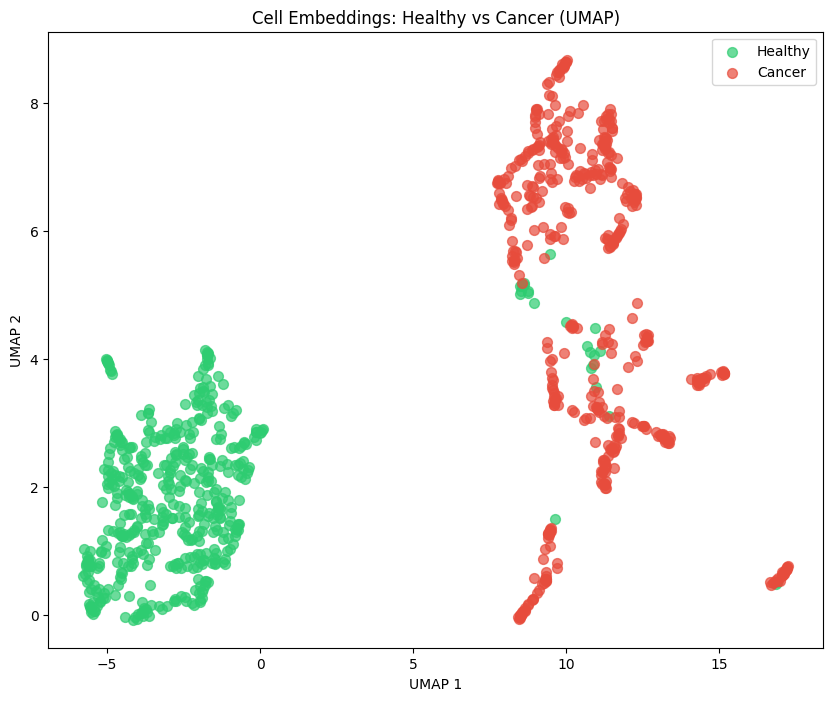

In [19]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP

# Combine embeddings and create labels
all_embeddings = np.vstack([healthy_embeddings, cancer_embeddings])
labels = np.array([0] * len(healthy_embeddings) + [1] * len(cancer_embeddings))
colors = ['#2ecc71', '#e74c3c']  # green for healthy, red for cancer
label_names = ['Healthy', 'Cancer']

print(f"Combined embeddings: {all_embeddings.shape}")
print(f"Labels: {len(labels)} (healthy=0, cancer=1)")

# Reduce to 50 dims with PCA first (standard practice for UMAP)
pca_50 = PCA(n_components=50)
embeddings_pca_50 = pca_50.fit_transform(all_embeddings)

# UMAP
umap_model = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embeddings_umap = umap_model.fit_transform(embeddings_pca_50)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
for i, (color, name) in enumerate(zip(colors, label_names)):
    mask = labels == i
    ax.scatter(embeddings_umap[mask, 0], embeddings_umap[mask, 1], c=color, label=name, alpha=0.7, s=50)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Cell Embeddings: Healthy vs Cancer (UMAP)')
ax.legend()
plt.show()

## 8. Understanding the Clustering: What's Driving the Separation?

Let's investigate why cancer and healthy cells separate so well. We'll look at:
1. Differential gene expression between conditions
2. Which genes contribute most to the embedding difference
3. Check for potential batch effects

In [20]:
# Check for batch effects: How many datasets/donors are represented?
print("=" * 60)
print("BATCH EFFECT CHECK: Dataset/Donor Diversity")
print("=" * 60)

# Check what metadata columns are available
print("\nAvailable metadata columns:")
print(healthy_adata.obs.columns.tolist())

# Check dataset diversity
if 'dataset_id' in healthy_adata.obs.columns:
    print(f"\nHealthy - unique datasets: {healthy_adata.obs['dataset_id'].nunique()}")
    print(f"Cancer - unique datasets: {cancer_adata.obs['dataset_id'].nunique()}")
    
if 'donor_id' in healthy_adata.obs.columns:
    print(f"\nHealthy - unique donors: {healthy_adata.obs['donor_id'].nunique()}")
    print(f"Cancer - unique donors: {cancer_adata.obs['donor_id'].nunique()}")

if 'cell_type' in healthy_adata.obs.columns:
    print(f"\nHealthy cell types:")
    print(healthy_adata.obs['cell_type'].value_counts().head(10))
    print(f"\nCancer cell types:")
    print(cancer_adata.obs['cell_type'].value_counts().head(10))

BATCH EFFECT CHECK: Dataset/Donor Diversity

Available metadata columns:
['soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'n_genes']

Healthy - unique datasets: 5
Cancer - unique datasets: 1

Healthy - unique donors: 162
Cancer - unique donors: 3

Healthy cell types:
cell_type
luminal adaptive secretory precursor cell of mammary gland    66
fibroblast                                                    55
fibroblast of mammary gland                                   52
blood vessel endot

In [21]:
# Find differentially expressed genes between healthy and cancer
import pandas as pd

print("=" * 60)
print("DIFFERENTIAL EXPRESSION ANALYSIS")
print("=" * 60)

# Get expression matrices (convert sparse to dense if needed)
healthy_expr = healthy_adata.X.toarray() if issparse(healthy_adata.X) else np.array(healthy_adata.X)
cancer_expr = cancer_adata.X.toarray() if issparse(cancer_adata.X) else np.array(cancer_adata.X)

# Calculate mean expression per gene in each condition
healthy_mean = pd.Series(healthy_expr.mean(axis=0), index=healthy_adata.var_names)
cancer_mean = pd.Series(cancer_expr.mean(axis=0), index=cancer_adata.var_names)

# Find common genes between both datasets
common_genes_expr = list(set(healthy_adata.var_names) & set(cancer_adata.var_names))
print(f"\nCommon genes between healthy and cancer: {len(common_genes_expr)}")

# Calculate fold change (cancer vs healthy)
# Add pseudocount to avoid division by zero
pseudocount = 0.1
log2fc = np.log2((cancer_mean[common_genes_expr] + pseudocount) / (healthy_mean[common_genes_expr] + pseudocount))
log2fc = log2fc.sort_values()

print(f"\n{'='*60}")
print("TOP 15 GENES HIGHER IN CANCER (vs Healthy)")
print("="*60)
print(f"{'Gene':<15} {'Log2FC':>10} {'Cancer Mean':>12} {'Healthy Mean':>12}")
print("-" * 60)
for gene in log2fc.tail(15).index[::-1]:
    print(f"{gene:<15} {log2fc[gene]:>10.2f} {cancer_mean[gene]:>12.2f} {healthy_mean[gene]:>12.2f}")

print(f"\n{'='*60}")
print("TOP 15 GENES HIGHER IN HEALTHY (vs Cancer)")
print("="*60)
print(f"{'Gene':<15} {'Log2FC':>10} {'Cancer Mean':>12} {'Healthy Mean':>12}")
print("-" * 60)
for gene in log2fc.head(15).index:
    print(f"{gene:<15} {log2fc[gene]:>10.2f} {cancer_mean[gene]:>12.2f} {healthy_mean[gene]:>12.2f}")

DIFFERENTIAL EXPRESSION ANALYSIS

Common genes between healthy and cancer: 13984

TOP 15 GENES HIGHER IN CANCER (vs Healthy)
Gene                Log2FC  Cancer Mean Healthy Mean
------------------------------------------------------------
ERBB4                 6.55        29.00         0.21
AFF3                  5.90        26.56         0.35
TTC6                  5.65         6.64         0.03
FBXL7                 5.51        11.46         0.15
BMPR1B                5.37         4.27         0.01
DACH1                 5.23         5.84         0.06
PTPRT                 5.15         4.46         0.03
TRPS1                 5.10        35.35         0.93
ESR1                  5.09         7.31         0.12
MRPS30-DT             5.00         3.41         0.01
CPB1                  4.99         3.60         0.02
PBX1                  4.83        12.69         0.35
PRKG1                 4.76         5.81         0.12
ANKS1B                4.71         3.72         0.05
GLI3               

In [22]:
# Visual demonstration: expression-weighted embedding for one cell

print("=" * 60)
print("VISUAL EXAMPLE: How One Cell's Embedding is Computed")
print("=" * 60)

# Use the first healthy cell
cell_idx = 0
common_genes = [g for g in healthy_adata.var_names if g in gene_to_embedding]
adata_filtered = healthy_adata[:, common_genes]

expression = adata_filtered.X[cell_idx]
if issparse(expression):
    expression = expression.toarray().flatten()
else:
    expression = np.asarray(expression).flatten()

# Normalize
weights = expression / expression.sum()

# Get top 5 genes by weight
top_k = 5
top_idx = np.argsort(weights)[::-1][:top_k]

print(f"\nCell has {np.sum(expression > 0)} expressed genes")
print(f"Total counts: {expression.sum():.0f}")
print(f"\nTop {top_k} genes by weight:")
print("-" * 60)

# Show the weighted contribution
cumulative_emb = np.zeros(512)
for i, idx in enumerate(top_idx):
    gene = common_genes[idx]
    w = weights[idx]
    emb = gene_to_embedding[gene]
    contribution = w * emb
    cumulative_emb += contribution
    
    print(f"\n{i+1}. {gene}")
    print(f"   Raw counts: {expression[idx]:.0f}")
    print(f"   Weight: {w:.4f} ({w*100:.2f}% of cell embedding)")
    print(f"   Embedding norm: {np.linalg.norm(emb):.3f}")
    print(f"   Contribution norm: {np.linalg.norm(contribution):.5f}")

print(f"\n" + "=" * 60)
print(f"After top {top_k} genes: cumulative norm = {np.linalg.norm(cumulative_emb):.4f}")
print(f"Final cell embedding norm: {np.linalg.norm(healthy_embeddings[cell_idx]):.4f}")
print(f"Top {top_k} genes account for {np.linalg.norm(cumulative_emb)/np.linalg.norm(healthy_embeddings[cell_idx])*100:.1f}% of embedding magnitude")

VISUAL EXAMPLE: How One Cell's Embedding is Computed

Cell has 2878 expressed genes
Total counts: 11218

Top 5 genes by weight:
------------------------------------------------------------

1. HLA-DPA1
   Raw counts: 172
   Weight: 0.0153 (1.53% of cell embedding)
   Embedding norm: 3.374
   Contribution norm: 0.05173

2. HLA-DRA
   Raw counts: 160
   Weight: 0.0143 (1.43% of cell embedding)
   Embedding norm: 3.706
   Contribution norm: 0.05286

3. FTL
   Raw counts: 140
   Weight: 0.0125 (1.25% of cell embedding)
   Embedding norm: 3.632
   Contribution norm: 0.04532

4. TPT1
   Raw counts: 138
   Weight: 0.0123 (1.23% of cell embedding)
   Embedding norm: 2.891
   Contribution norm: 0.03556

5. MT-CO1
   Raw counts: 134
   Weight: 0.0119 (1.19% of cell embedding)
   Embedding norm: 4.061
   Contribution norm: 0.04851

After top 5 genes: cumulative norm = 0.1649
Final cell embedding norm: 2.1651
Top 5 genes account for 7.6% of embedding magnitude


## 9. Cancer Direction Analysis in 512-dim Embedding Space

Compute the cancer direction vector (healthy centroid → cancer centroid) in the full 512-dimensional space, then find genes that:
1. Have embeddings aligned with this direction
2. Are differentially expressed between healthy and cancer

In [23]:
# Compute centroids and cancer direction in 512-dim space
print("=" * 70)
print("CANCER DIRECTION VECTOR IN 512-DIM EMBEDDING SPACE")
print("=" * 70)

# Centroids (center of mass)
healthy_centroid = healthy_embeddings.mean(axis=0)  # shape: (512,)
cancer_centroid = cancer_embeddings.mean(axis=0)    # shape: (512,)

# Cancer direction vector: points from healthy to cancer
cancer_direction = cancer_centroid - healthy_centroid  # shape: (512,)
cancer_direction_unit = cancer_direction / np.linalg.norm(cancer_direction)  # unit vector

print(f"\n512-dim Embedding Space Statistics:")
print(f"  Healthy centroid norm:     {np.linalg.norm(healthy_centroid):.4f}")
print(f"  Cancer centroid norm:      {np.linalg.norm(cancer_centroid):.4f}")
print(f"  Cancer direction norm:     {np.linalg.norm(cancer_direction):.4f}  (distance between centroids)")
print(f"  Cosine similarity:         {np.dot(healthy_centroid, cancer_centroid) / (np.linalg.norm(healthy_centroid) * np.linalg.norm(cancer_centroid)):.4f}")

# Project all cells onto cancer direction
healthy_proj = healthy_embeddings @ cancer_direction_unit
cancer_proj = cancer_embeddings @ cancer_direction_unit

print(f"\nCell projections onto cancer direction:")
print(f"  Healthy: {healthy_proj.mean():.4f} ± {healthy_proj.std():.4f}  (range: [{healthy_proj.min():.4f}, {healthy_proj.max():.4f}])")
print(f"  Cancer:  {cancer_proj.mean():.4f} ± {cancer_proj.std():.4f}  (range: [{cancer_proj.min():.4f}, {cancer_proj.max():.4f}])")
print(f"  Separation (cancer - healthy): {cancer_proj.mean() - healthy_proj.mean():.4f}")

CANCER DIRECTION VECTOR IN 512-DIM EMBEDDING SPACE

512-dim Embedding Space Statistics:
  Healthy centroid norm:     2.1565
  Cancer centroid norm:      2.0969
  Cancer direction norm:     0.8451  (distance between centroids)
  Cosine similarity:         0.9214

Cell projections onto cancer direction:
  Healthy: -0.5726 ± 0.2404  (range: [-1.0398, 0.2874])
  Cancer:  0.2725 ± 0.0545  (range: [0.0522, 0.4759])
  Separation (cancer - healthy): 0.8451


In [24]:
# For each gene, compute:
# 1. Alignment with cancer direction (dot product of gene embedding with cancer direction)
# 2. Differential expression (log2 fold change)
# Genes that are BOTH aligned AND differentially expressed are most important

print("=" * 70)
print("GENE CONTRIBUTION TO CANCER DIRECTION")
print("=" * 70)

# Get common genes (expressed in both conditions AND have embeddings)
common_genes_all = list(set(healthy_adata.var_names) & set(cancer_adata.var_names) & set(gene_to_embedding.keys()))
print(f"\nAnalyzing {len(common_genes_all)} genes (common to healthy, cancer, and have embeddings)")

# Compute alignment and differential expression for each gene
gene_analysis = []
for gene in common_genes_all:
    emb = gene_to_embedding[gene]
    
    # Alignment with cancer direction (positive = points toward cancer)
    alignment = np.dot(emb, cancer_direction_unit)
    
    # Differential expression
    h_expr = healthy_mean.get(gene, 0)
    c_expr = cancer_mean.get(gene, 0)
    log2fc_val = np.log2((c_expr + 0.1) / (h_expr + 0.1))
    
    gene_analysis.append({
        'gene': gene,
        'alignment': alignment,
        'log2FC': log2fc_val,
        'healthy_expr': h_expr,
        'cancer_expr': c_expr,
        # Combined score: alignment * log2FC
        # Positive when: (aligned toward cancer AND upregulated in cancer) OR (aligned toward healthy AND upregulated in healthy)
        'contribution_score': alignment * log2fc_val
    })

gene_df = pd.DataFrame(gene_analysis).sort_values('contribution_score', ascending=False)
print(f"Gene analysis complete.")

GENE CONTRIBUTION TO CANCER DIRECTION

Analyzing 12502 genes (common to healthy, cancer, and have embeddings)
Gene analysis complete.


In [25]:
# TOP GENES DRIVING THE CANCER DIRECTION
# These genes have embeddings aligned with cancer direction AND are upregulated in cancer

print("=" * 70)
print("TOP 20 GENES DRIVING CANCER DIRECTION")
print("(Embedding aligned toward cancer AND upregulated in cancer)")
print("=" * 70)
print(f"\n{'Gene':<12} {'Alignment':>10} {'Log2FC':>10} {'Score':>10} {'Healthy':>10} {'Cancer':>10}")
print("-" * 70)

for _, row in gene_df.head(20).iterrows():
    print(f"{row['gene']:<12} {row['alignment']:>10.3f} {row['log2FC']:>10.2f} {row['contribution_score']:>10.2f} {row['healthy_expr']:>10.2f} {row['cancer_expr']:>10.2f}")

TOP 20 GENES DRIVING CANCER DIRECTION
(Embedding aligned toward cancer AND upregulated in cancer)

Gene          Alignment     Log2FC      Score    Healthy     Cancer
----------------------------------------------------------------------
RPL41            -2.583      -6.95      17.95      54.37       0.34
RPL39            -2.168      -8.14      17.65      36.03       0.03
RPL32            -1.901      -6.95      13.21      35.47       0.19
RPS28            -1.685      -7.62      12.84      32.17       0.06
RPL34            -1.796      -6.71      12.05      32.94       0.22
FAU              -1.751      -6.56      11.49      15.60       0.07
RPS29            -1.958      -5.85      11.46      15.74       0.17
RPS23            -1.736      -6.59      11.45      30.63       0.22
RPL36            -1.796      -6.31      11.33      25.93       0.23
RPL35A           -1.742      -6.47      11.27      22.21       0.15
RPS27            -1.473      -7.55      11.11      32.81       0.08
RPL18         

In [26]:
# TOP GENES DRIVING THE HEALTHY DIRECTION
# These genes have embeddings aligned AWAY from cancer AND are upregulated in healthy

print("=" * 70)
print("TOP 20 GENES DRIVING HEALTHY DIRECTION")
print("(Embedding aligned toward healthy AND upregulated in healthy)")
print("=" * 70)
print(f"\n{'Gene':<12} {'Alignment':>10} {'Log2FC':>10} {'Score':>10} {'Healthy':>10} {'Cancer':>10}")
print("-" * 70)

for _, row in gene_df.tail(20).iloc[::-1].iterrows():
    print(f"{row['gene']:<12} {row['alignment']:>10.3f} {row['log2FC']:>10.2f} {row['contribution_score']:>10.2f} {row['healthy_expr']:>10.2f} {row['cancer_expr']:>10.2f}")

TOP 20 GENES DRIVING HEALTHY DIRECTION
(Embedding aligned toward healthy AND upregulated in healthy)

Gene          Alignment     Log2FC      Score    Healthy     Cancer
----------------------------------------------------------------------
SAMD12           -0.900       3.85      -3.47       0.10       2.73
KDM6B             1.093      -2.99      -3.26       1.26       0.07
FHIT             -0.822       3.60      -2.96       0.20       3.54
NFKBIA            0.506      -5.75      -2.91      11.00       0.11
UMAD1            -0.877       3.30      -2.90       0.07       1.60
TNFAIP3           0.787      -3.64      -2.87       1.68       0.04
TRIQK            -1.556       1.78      -2.76       0.09       0.54
ACYP2            -1.178       2.34      -2.75       0.19       1.37
SCGB2B2          -1.327       2.03      -2.69       0.01       0.36
LIN52            -1.248       2.03      -2.53       0.03       0.44
KANTR            -1.203       2.01      -2.42       0.04       0.47
COA1       

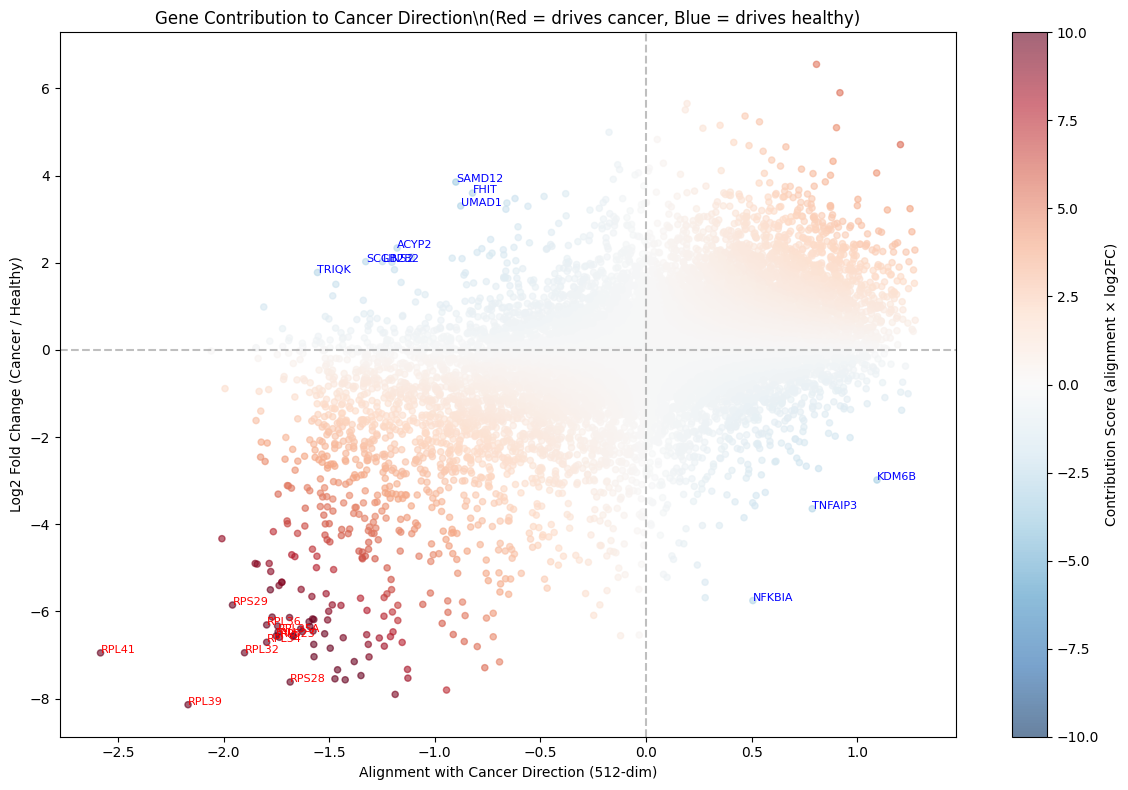

In [27]:
# Visualize: scatter plot of alignment vs log2FC
fig, ax = plt.subplots(figsize=(12, 8))

# Color by contribution score
scatter = ax.scatter(
    gene_df['alignment'], 
    gene_df['log2FC'],
    c=gene_df['contribution_score'],
    cmap='RdBu_r',
    alpha=0.6,
    s=20,
    vmin=-10, vmax=10
)
plt.colorbar(scatter, label='Contribution Score (alignment × log2FC)')

# Mark top genes
top_cancer = gene_df.head(10)
top_healthy = gene_df.tail(10)

for _, row in top_cancer.iterrows():
    ax.annotate(row['gene'], (row['alignment'], row['log2FC']), fontsize=8, color='red')
for _, row in top_healthy.iterrows():
    ax.annotate(row['gene'], (row['alignment'], row['log2FC']), fontsize=8, color='blue')

ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Alignment with Cancer Direction (512-dim)')
ax.set_ylabel('Log2 Fold Change (Cancer / Healthy)')
ax.set_title('Gene Contribution to Cancer Direction\\n(Red = drives cancer, Blue = drives healthy)')

plt.tight_layout()
plt.show()

In [28]:
# Export gene lists and save vectors for pathway analysis
output_dir = PROJECT_ROOT / "data" / "analysis"
output_dir.mkdir(parents=True, exist_ok=True)

print("=" * 70)
print("EXPORTING RESULTS")
print("=" * 70)

# Save cancer direction vector (512-dim)
np.save(output_dir / "cancer_direction_512d.npy", cancer_direction_unit)
np.save(output_dir / "healthy_centroid_512d.npy", healthy_centroid)
np.save(output_dir / "cancer_centroid_512d.npy", cancer_centroid)
print(f"\n1. Cancer direction vector (512-dim): {output_dir / 'cancer_direction_512d.npy'}")
print(f"   Healthy centroid: {output_dir / 'healthy_centroid_512d.npy'}")
print(f"   Cancer centroid: {output_dir / 'cancer_centroid_512d.npy'}")

# Save full gene analysis table
gene_df.to_csv(output_dir / "gene_contribution_analysis.csv", index=False)
print(f"\n2. Full gene analysis: {output_dir / 'gene_contribution_analysis.csv'}")

# Top cancer-driving genes (positive contribution score, top 100)
top_cancer_genes = gene_df[gene_df['contribution_score'] > 0].head(100)['gene'].tolist()
with open(output_dir / "top_cancer_genes.txt", "w") as f:
    f.write("\n".join(top_cancer_genes))
print(f"\n3. Top cancer-driving genes: {output_dir / 'top_cancer_genes.txt'} ({len(top_cancer_genes)} genes)")

# Top healthy-driving genes (negative contribution score, bottom 100)  
top_healthy_genes = gene_df[gene_df['contribution_score'] < 0].tail(100)['gene'].tolist()
with open(output_dir / "top_healthy_genes.txt", "w") as f:
    f.write("\n".join(top_healthy_genes))
print(f"\n4. Top healthy-driving genes: {output_dir / 'top_healthy_genes.txt'} ({len(top_healthy_genes)} genes)")

print(f"\n" + "=" * 70)
print("Use these gene lists for pathway analysis at:")
print("  - Enrichr: https://maayanlab.cloud/Enrichr/")
print("  - g:Profiler: https://biit.cs.ut.ee/gprofiler/")
print("=" * 70)

EXPORTING RESULTS

1. Cancer direction vector (512-dim): /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/cancer_direction_512d.npy
   Healthy centroid: /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/healthy_centroid_512d.npy
   Cancer centroid: /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/cancer_centroid_512d.npy

2. Full gene analysis: /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/gene_contribution_analysis.csv

3. Top cancer-driving genes: /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/top_cancer_genes.txt (100 genes)

4. Top healthy-driving genes: /mnt/c/Users/zhaoj/projects/funcCell/data/analysis/top_healthy_genes.txt (100 genes)

Use these gene lists for pathway analysis at:
  - Enrichr: https://maayanlab.cloud/Enrichr/
  - g:Profiler: https://biit.cs.ut.ee/gprofiler/


## 10. Boundary-Based Classifiers

Two approaches to classify cells as healthy vs cancer:
1. **Threshold on Cancer Direction**: Project cells onto cancer direction vector, find optimal threshold (uses centroid difference)
2. **Logistic Regression**: Learn a linear decision boundary in 512-dim space (uses both class labels)

Note: Training metrics shown first, then we'll test on NEW cells from Census.

In [29]:
# Classifier 1: Threshold on Cancer Direction
# Project all cells onto the cancer direction vector and find optimal threshold

from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

print("=" * 70)
print("CLASSIFIER 1: THRESHOLD ON CANCER DIRECTION")
print("=" * 70)

# Project all cells onto cancer direction (already computed: healthy_proj, cancer_proj)
all_projections = np.concatenate([healthy_proj, cancer_proj])

# Compute ROC curve to find optimal threshold
fpr, tpr, thresholds = roc_curve(labels, all_projections)
roc_auc = auc(fpr, tpr)

# Find optimal threshold using Youden's J statistic (maximizes TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nProjection Statistics:")
print(f"  Healthy cells: {healthy_proj.mean():.4f} ± {healthy_proj.std():.4f}")
print(f"  Cancer cells:  {cancer_proj.mean():.4f} ± {cancer_proj.std():.4f}")
print(f"\nOptimal threshold: {optimal_threshold:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Make predictions
threshold_predictions = (all_projections > optimal_threshold).astype(int)

# Evaluate
print(f"\nClassification Report (Threshold Classifier):")
print(classification_report(labels, threshold_predictions, target_names=['Healthy', 'Cancer']))

# Confusion matrix
cm_threshold = confusion_matrix(labels, threshold_predictions)
print(f"Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Healthy  Cancer")
print(f"Actual Healthy   {cm_threshold[0,0]:>6}  {cm_threshold[0,1]:>6}")
print(f"       Cancer    {cm_threshold[1,0]:>6}  {cm_threshold[1,1]:>6}")

CLASSIFIER 1: THRESHOLD ON CANCER DIRECTION

Projection Statistics:
  Healthy cells: -0.5726 ± 0.2404
  Cancer cells:  0.2725 ± 0.0545

Optimal threshold: 0.1079
ROC AUC: 0.9932

Classification Report (Threshold Classifier):
              precision    recall  f1-score   support

     Healthy       0.99      0.96      0.98       500
      Cancer       0.96      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
                 Predicted
                 Healthy  Cancer
Actual Healthy      482      18
       Cancer         4     496


In [30]:
# Classifier 2: Logistic Regression (Linear Boundary)
# Learn a linear decision boundary using both healthy and cancer labels

from sklearn.linear_model import LogisticRegression

print("=" * 70)
print("CLASSIFIER 2: LOGISTIC REGRESSION")
print("=" * 70)

# Train on all data (we'll test on new data later)
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(all_embeddings, labels)

# Predict
logreg_predictions = logreg.predict(all_embeddings)
logreg_proba = logreg.predict_proba(all_embeddings)[:, 1]  # P(cancer)

print(f"\nTraining Logistic Regression on {len(all_embeddings)} cells...")
print(f"  Boundary type: Linear hyperplane in 512-dim space")

# Evaluate (on training data - will test on new data below)
print(f"\nClassification Report (Logistic Regression - TRAINING DATA):")
print(classification_report(labels, logreg_predictions, target_names=['Healthy', 'Cancer']))

# Confusion matrix
cm_logreg = confusion_matrix(labels, logreg_predictions)
print(f"Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Healthy  Cancer")
print(f"Actual Healthy   {cm_logreg[0,0]:>6}  {cm_logreg[0,1]:>6}")
print(f"       Cancer    {cm_logreg[1,0]:>6}  {cm_logreg[1,1]:>6}")

CLASSIFIER 2: LOGISTIC REGRESSION

Training Logistic Regression on 1000 cells...
  Boundary type: Linear hyperplane in 512-dim space

Classification Report (Logistic Regression - TRAINING DATA):
              precision    recall  f1-score   support

     Healthy       1.00      0.95      0.97       500
      Cancer       0.95      1.00      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

Confusion Matrix:
                 Predicted
                 Healthy  Cancer
Actual Healthy      473      27
       Cancer         0     500


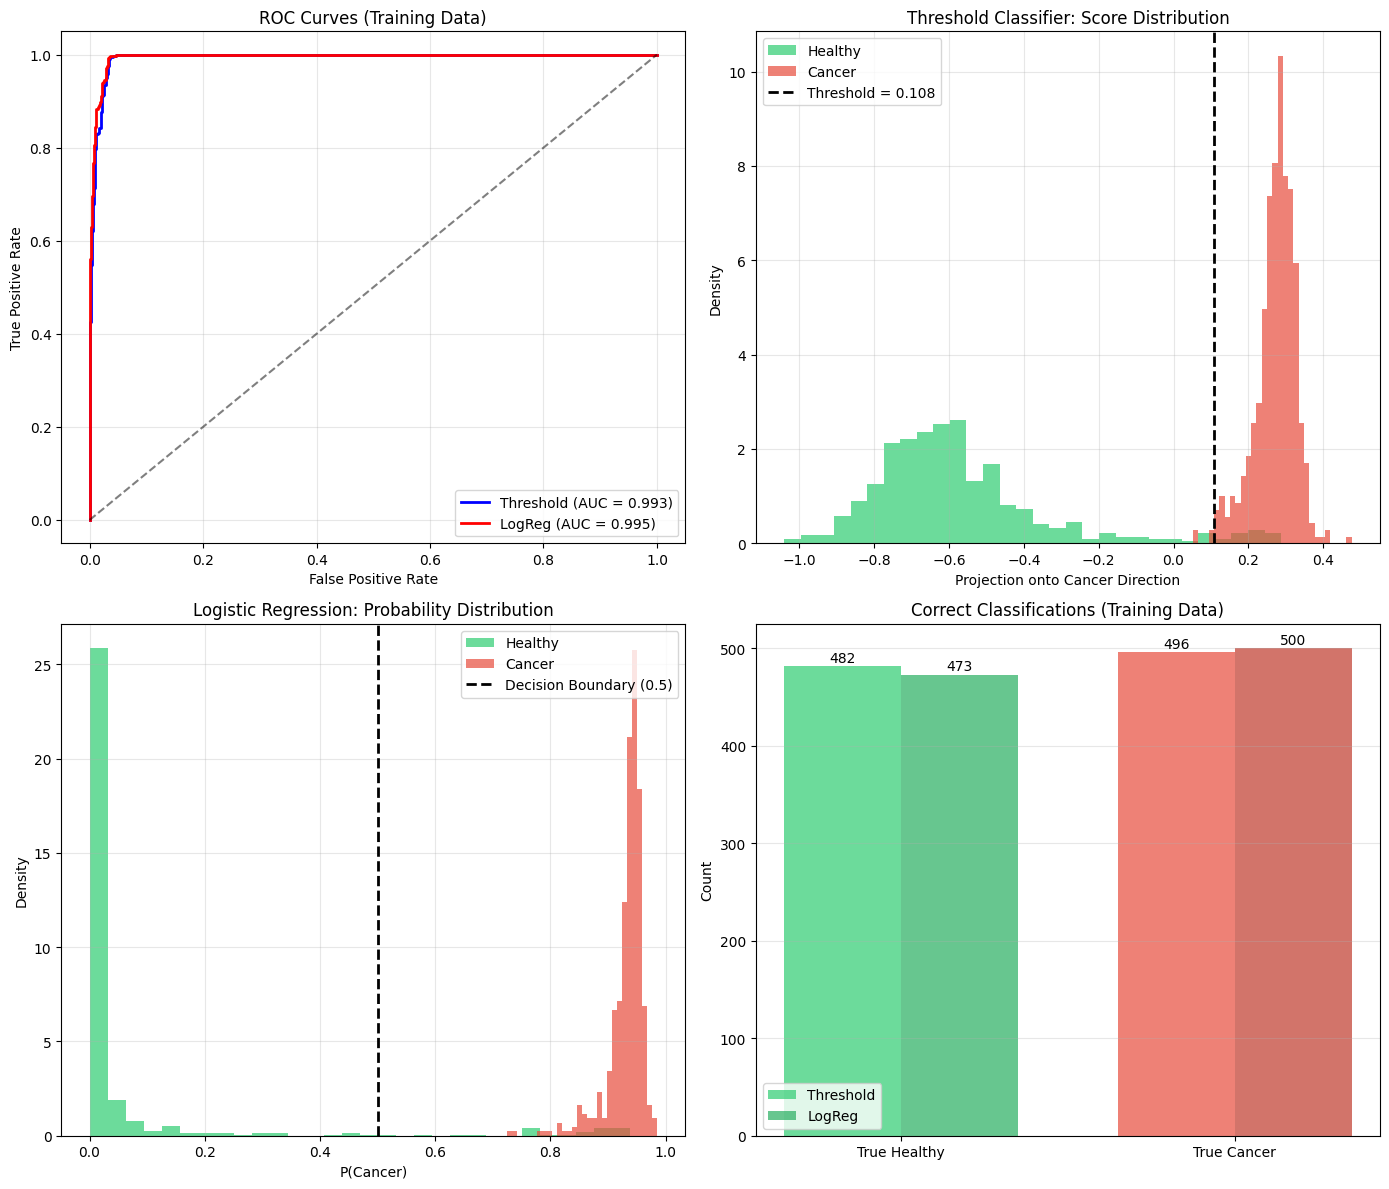


CLASSIFIER COMPARISON (TRAINING DATA)

Metric                          Threshold          LogReg
-------------------------------------------------------
ROC AUC                             0.993           0.995
Accuracy                            0.978           0.973


In [31]:
# Comparison Visualization: ROC curves and score distributions

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'Threshold (AUC = {roc_auc:.3f})')
fpr_logreg, tpr_logreg, _ = roc_curve(labels, logreg_proba)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
ax1.plot(fpr_logreg, tpr_logreg, 'r-', linewidth=2, label=f'LogReg (AUC = {roc_auc_logreg:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves (Training Data)')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Score Distributions - Threshold Classifier
ax2 = axes[0, 1]
ax2.hist(healthy_proj, bins=30, alpha=0.7, color='#2ecc71', label='Healthy', density=True)
ax2.hist(cancer_proj, bins=30, alpha=0.7, color='#e74c3c', label='Cancer', density=True)
ax2.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {optimal_threshold:.3f}')
ax2.set_xlabel('Projection onto Cancer Direction')
ax2.set_ylabel('Density')
ax2.set_title('Threshold Classifier: Score Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Score Distributions - LogReg
ax3 = axes[1, 0]
healthy_proba = logreg_proba[:len(healthy_embeddings)]
cancer_proba = logreg_proba[len(healthy_embeddings):]
ax3.hist(healthy_proba, bins=30, alpha=0.7, color='#2ecc71', label='Healthy', density=True)
ax3.hist(cancer_proba, bins=30, alpha=0.7, color='#e74c3c', label='Cancer', density=True)
ax3.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Boundary (0.5)')
ax3.set_xlabel('P(Cancer)')
ax3.set_ylabel('Density')
ax3.set_title('Logistic Regression: Probability Distribution')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Summary comparison
ax4 = axes[1, 1]
x = np.arange(2)
width = 0.35
bars1 = ax4.bar(x - width/2, [cm_threshold[0,0], cm_threshold[1,1]], width, 
                label='Threshold', color=['#2ecc71', '#e74c3c'], alpha=0.7)
bars2 = ax4.bar(x + width/2, [cm_logreg[0,0], cm_logreg[1,1]], width,
                label='LogReg', color=['#27ae60', '#c0392b'], alpha=0.7)
ax4.set_ylabel('Count')
ax4.set_title('Correct Classifications (Training Data)')
ax4.set_xticks(x)
ax4.set_xticklabels(['True Healthy', 'True Cancer'])
ax4.legend()
for bar in list(bars1) + list(bars2):
    height = bar.get_height()
    ax4.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 70)
print("CLASSIFIER COMPARISON (TRAINING DATA)")
print("=" * 70)
threshold_acc = (cm_threshold[0,0] + cm_threshold[1,1]) / cm_threshold.sum()
logreg_acc = (cm_logreg[0,0] + cm_logreg[1,1]) / cm_logreg.sum()
print(f"\n{'Metric':<25} {'Threshold':>15} {'LogReg':>15}")
print("-" * 55)
print(f"{'ROC AUC':<25} {roc_auc:>15.3f} {roc_auc_logreg:>15.3f}")
print(f"{'Accuracy':<25} {threshold_acc:>15.3f} {logreg_acc:>15.3f}")

## 11. Test on New Data from Census

Query fresh cells from CELLxGENE Census to evaluate classifier generalization.

In [32]:
# Query NEW test cells from Census (different from training)
print("=" * 70)
print("FETCHING NEW TEST DATA FROM CENSUS")
print("=" * 70)

N_TEST = 200  # cells per condition

with cellxgene_census.open_soma(census_version="stable") as census:
    # Get cell IDs (excluding training IDs)
    all_healthy_obs = census["census_data"]["homo_sapiens"].obs.read(
        value_filter=healthy_filter,
        column_names=["soma_joinid"]
    ).concat().to_pandas()
    
    all_cancer_obs = census["census_data"]["homo_sapiens"].obs.read(
        value_filter=cancer_filter,
        column_names=["soma_joinid"]
    ).concat().to_pandas()
    
    # Exclude training cell IDs
    available_healthy = all_healthy_obs[~all_healthy_obs["soma_joinid"].isin(healthy_sample_ids)]
    available_cancer = all_cancer_obs[~all_cancer_obs["soma_joinid"].isin(cancer_sample_ids)]
    
    print(f"Available healthy cells (excluding training): {len(available_healthy)}")
    print(f"Available cancer cells (excluding training): {len(available_cancer)}")
    
    # Sample new test cells
    np.random.seed(99999)  # Different seed
    test_healthy_ids = available_healthy["soma_joinid"].sample(n=min(N_TEST, len(available_healthy))).tolist()
    test_cancer_ids = available_cancer["soma_joinid"].sample(n=min(N_TEST, len(available_cancer))).tolist()
    
    print(f"\nSampled {len(test_healthy_ids)} healthy + {len(test_cancer_ids)} cancer TEST cells")
    
    # Fetch expression data
    print("\nFetching test cell expression data...")
    test_healthy_adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        measurement_name="RNA",
        X_name="raw",
        obs_coords=test_healthy_ids,
    )
    test_cancer_adata = cellxgene_census.get_anndata(
        census=census,
        organism="Homo sapiens",
        measurement_name="RNA",
        X_name="raw",
        obs_coords=test_cancer_ids,
    )

print(f"Test healthy: {test_healthy_adata.n_obs} cells")
print(f"Test cancer: {test_cancer_adata.n_obs} cells")

# Apply same QC
sc.pp.filter_cells(test_healthy_adata, min_genes=min_genes)
sc.pp.filter_cells(test_cancer_adata, min_genes=min_genes)

# Fix gene names
test_healthy_adata.var_names = test_healthy_adata.var['feature_name'].values
test_cancer_adata.var_names = test_cancer_adata.var['feature_name'].values

print(f"After QC - healthy: {test_healthy_adata.n_obs}, cancer: {test_cancer_adata.n_obs}")

FETCHING NEW TEST DATA FROM CENSUS


The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


Available healthy cells (excluding training): 1726082
Available cancer cells (excluding training): 33664

Sampled 200 healthy + 200 cancer TEST cells

Fetching test cell expression data...


/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/c/Users/zhaoj/projects/funcCell/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Test healthy: 200 cells
Test cancer: 200 cells
After QC - healthy: 200, cancer: 200


In [33]:
# Generate embeddings for test cells
print("=" * 70)
print("GENERATING TEST CELL EMBEDDINGS")
print("=" * 70)

test_healthy_emb = embedder.create_cell_embeddings(test_healthy_adata)
test_cancer_emb = embedder.create_cell_embeddings(test_cancer_adata)

print(f"Test healthy embeddings: {test_healthy_emb.shape}")
print(f"Test cancer embeddings: {test_cancer_emb.shape}")

# Combine test data
test_embeddings = np.vstack([test_healthy_emb, test_cancer_emb])
test_labels = np.array([0] * len(test_healthy_emb) + [1] * len(test_cancer_emb))

print(f"\nTotal test set: {len(test_labels)} cells")

GENERATING TEST CELL EMBEDDINGS
Test healthy embeddings: (200, 512)
Test cancer embeddings: (200, 512)

Total test set: 400 cells


CLASSIFIER EVALUATION ON TEST DATA

THRESHOLD CLASSIFIER (TEST DATA)
              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96       200
      Cancer       0.96      0.97      0.97       200

    accuracy                           0.96       400
   macro avg       0.97      0.96      0.96       400
weighted avg       0.97      0.96      0.96       400


LOGISTIC REGRESSION (TEST DATA)
              precision    recall  f1-score   support

     Healthy       1.00      0.95      0.97       200
      Cancer       0.95      1.00      0.98       200

    accuracy                           0.97       400
   macro avg       0.98      0.97      0.97       400
weighted avg       0.98      0.97      0.97       400


FINAL COMPARISON: TEST DATA PERFORMANCE

Metric                          Threshold          LogReg
-------------------------------------------------------
ROC AUC                             0.987           0.989
Accuracy                      

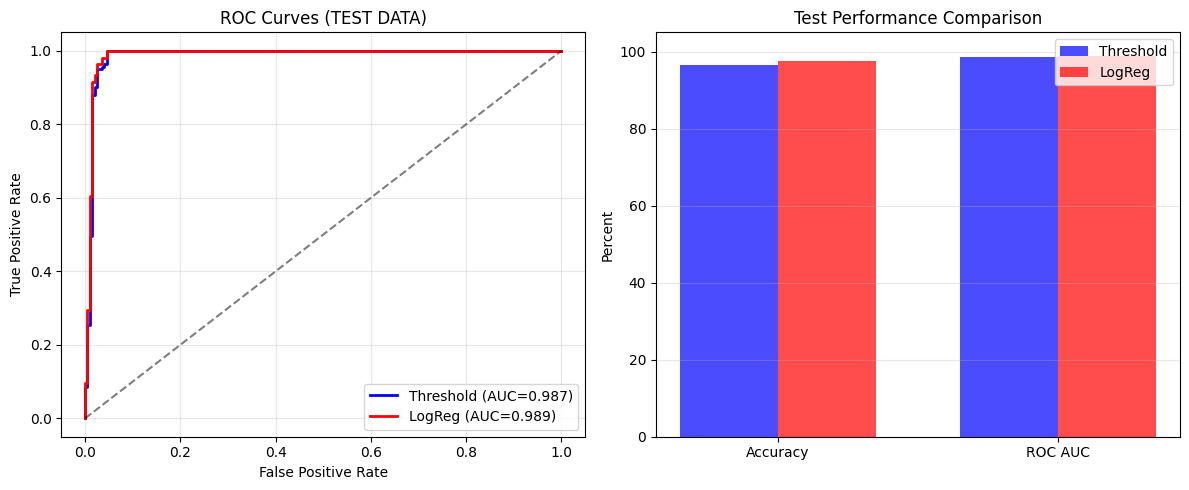

In [34]:
# Evaluate classifiers on TEST data
print("=" * 70)
print("CLASSIFIER EVALUATION ON TEST DATA")
print("=" * 70)

# 1. Threshold classifier
test_proj = test_embeddings @ cancer_direction_unit
test_threshold_pred = (test_proj > optimal_threshold).astype(int)

# 2. LogReg
test_logreg_pred = logreg.predict(test_embeddings)
test_logreg_proba = logreg.predict_proba(test_embeddings)[:, 1]

# Results
print("\n" + "=" * 70)
print("THRESHOLD CLASSIFIER (TEST DATA)")
print("=" * 70)
print(classification_report(test_labels, test_threshold_pred, target_names=['Healthy', 'Cancer']))
cm_test_threshold = confusion_matrix(test_labels, test_threshold_pred)

print("\n" + "=" * 70)
print("LOGISTIC REGRESSION (TEST DATA)")
print("=" * 70)
print(classification_report(test_labels, test_logreg_pred, target_names=['Healthy', 'Cancer']))
cm_test_logreg = confusion_matrix(test_labels, test_logreg_pred)

# ROC AUC on test
fpr_test_th, tpr_test_th, _ = roc_curve(test_labels, test_proj)
fpr_test_lr, tpr_test_lr, _ = roc_curve(test_labels, test_logreg_proba)
auc_test_th = auc(fpr_test_th, tpr_test_th)
auc_test_lr = auc(fpr_test_lr, tpr_test_lr)

# Summary
print("\n" + "=" * 70)
print("FINAL COMPARISON: TEST DATA PERFORMANCE")
print("=" * 70)
acc_test_th = (cm_test_threshold[0,0] + cm_test_threshold[1,1]) / cm_test_threshold.sum()
acc_test_lr = (cm_test_logreg[0,0] + cm_test_logreg[1,1]) / cm_test_logreg.sum()

print(f"\n{'Metric':<25} {'Threshold':>15} {'LogReg':>15}")
print("-" * 55)
print(f"{'ROC AUC':<25} {auc_test_th:>15.3f} {auc_test_lr:>15.3f}")
print(f"{'Accuracy':<25} {acc_test_th:>15.3f} {acc_test_lr:>15.3f}")
print(f"{'True Positives':<25} {cm_test_threshold[1,1]:>15} {cm_test_logreg[1,1]:>15}")
print(f"{'True Negatives':<25} {cm_test_threshold[0,0]:>15} {cm_test_logreg[0,0]:>15}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
ax1.plot(fpr_test_th, tpr_test_th, 'b-', lw=2, label=f'Threshold (AUC={auc_test_th:.3f})')
ax1.plot(fpr_test_lr, tpr_test_lr, 'r-', lw=2, label=f'LogReg (AUC={auc_test_lr:.3f})')
ax1.plot([0,1], [0,1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves (TEST DATA)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
x = np.arange(2)
width = 0.35
ax2.bar(x - width/2, [acc_test_th*100, auc_test_th*100], width, label='Threshold', color='blue', alpha=0.7)
ax2.bar(x + width/2, [acc_test_lr*100, auc_test_lr*100], width, label='LogReg', color='red', alpha=0.7)
ax2.set_ylabel('Percent')
ax2.set_title('Test Performance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(['Accuracy', 'ROC AUC'])
ax2.legend()
ax2.set_ylim(0, 105)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates the FuncCell pipeline for creating function-aware cell embeddings:

1. **Data**: 500 healthy + 500 cancer breast cells from CELLxGENE Census (training)
2. **Embeddings**: 512-dim cell embeddings via expression-weighted sum of ProteinBERT gene embeddings
3. **Visualization**: UMAP shows clear separation between healthy and cancer cells
4. **Cancer Direction**: Computed in full 512-dim space with gene contribution analysis
5. **Classification**: Two boundary-based classifiers:
   - **Threshold on Cancer Direction**: Simple 1D projection (uses centroid difference)
   - **Logistic Regression**: Linear hyperplane in 512-dim space (uses class labels)
6. **Validation**: Tested on 200 NEW cells from Census (not used in training)

Both classifiers leverage the functional embedding space rather than raw gene expression.